In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.animation
sns.set_theme(rc={"figure.figsize": (16, 4)})

In [2]:
df = pd.read_csv('../data/sp500/csv/AAPL.csv', parse_dates=['Date'], date_format='%d-%m-%Y')

In [3]:
# df['Return'] = (df['Close'] - df['Close'].shift(1))/df['Close'].shift(1)
df['Return'] = df['Close'].pct_change()
df

,Date,Low,Open,Volume,High,Close,Adjusted Close,Return
0,1980-12-12,0.128348,0.128348,469033600,0.128906,0.128348,0.099874,NaN
1,1980-12-15,0.121652,0.122210,175884800,0.122210,0.121652,0.094663,-0.052171
2,1980-12-16,0.112723,0.113281,105728000,0.113281,0.112723,0.087715,-0.073398
3,1980-12-17,0.115513,0.115513,86441600,0.116071,0.115513,0.089886,0.024751
4,1980-12-18,0.118862,0.118862,73449600,0.119420,0.118862,0.092492,0.028992
...,...,...,...,...,...,...,...,...
10585,2022-12-06,141.919998,147.070007,64727200,147.300003,142.910004,142.910004,-0.025370
10586,2022-12-07,140.000000,142.190002,69721100,143.369995,140.940002,140.940002,-0.013785
10587,2022-12-08,141.100006,142.360001,62128300,143.520004,142.649994,142.649994,0.012133
10588,2022-12-09,140.899994,142.339996,76069500,145.570007,142.160004,142.160004,-0.003435


In [4]:
df_w = df.set_index('Date').resample('W').mean()
df_w

,Low,Open,Volume,High,Close,Adjusted Close,Return
Date,,,,,,,
1980-12-14,0.128348,0.128348,469033600.0,0.128906,0.128348,0.099874,NaN
1980-12-21,0.118973,0.119196,98026880.0,0.119531,0.118973,0.092579,-0.002159
1980-12-28,0.143415,0.143415,46972800.0,0.143973,0.143415,0.111598,0.058951
1981-01-04,0.155971,0.156250,54863200.0,0.156669,0.155971,0.121369,-0.006925
1981-01-11,0.141964,0.142411,39580800.0,0.142522,0.141964,0.110469,-0.015069
...,...,...,...,...,...,...,...
2022-11-20,147.879996,149.812000,76535940.0,151.583997,149.823996,149.823996,0.002161
2022-11-27,147.777496,149.012501,51006375.0,150.375000,149.342499,149.342499,-0.005172
2022-12-04,143.308002,145.000000,80181200.0,147.460001,145.907999,145.907999,-0.000060


In [5]:
df.describe()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Return
count,10590,10590.000000,10590.000000,1.059000e+04,10590.000000,10590.000000,10590.000000,10589.000000
mean,2001-12-04 16:56:17.677053824,16.141083,16.323966,3.279583e+08,16.509548,16.332137,15.660945,0.001069
min,1980-12-12 00:00:00,0.049107,0.049665,0.000000e+00,0.049665,0.049107,0.038213,-0.518692
25%,1991-06-04 06:00:00,0.280134,0.286663,1.215564e+08,0.293699,0.286830,0.237230,-0.013112
50%,2001-11-29 12:00:00,0.477500,0.484375,2.151240e+08,0.493304,0.484375,0.401782,0.000000
75%,2012-06-05 18:00:00,15.800536,16.009286,4.070262e+08,16.179196,15.968750,13.831446,0.014708
max,2022-12-12 00:00:00,179.119995,182.630005,7.421641e+09,182.940002,182.009995,180.959732,0.332280
std,NaN,34.495971,34.904787,3.379551e+08,35.327844,34.928463,34.596768,0.028291


In [6]:
mean_return = df['Return'].mean()
std_return = df['Return'].std()
df['Return'].var()*100

0.0800355736837283

In [7]:
confidence_level = 0.95
z_score = norm.ppf(1 - confidence_level)
VaR = mean_return + z_score * std_return
VaR

-0.04546450369205857

In [8]:
T = 10 # VaR for 2 weeks ~ 10 workdays
-z_score * std_return * np.sqrt(T)

0.14715288732294118

<Axes: xlabel='Date', ylabel='Close'>

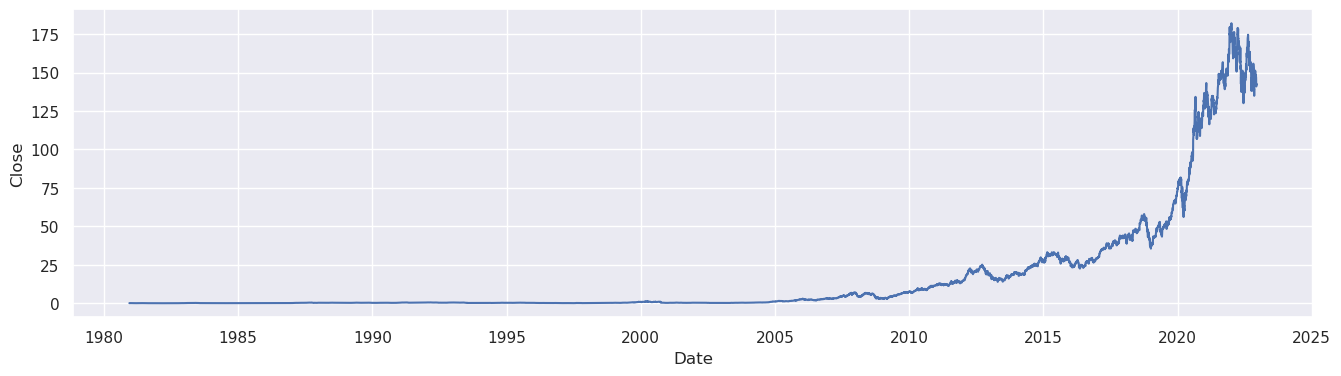

In [9]:
sns.lineplot(df, x='Date', y='Close')

<Axes: xlabel='Date', ylabel='Return'>

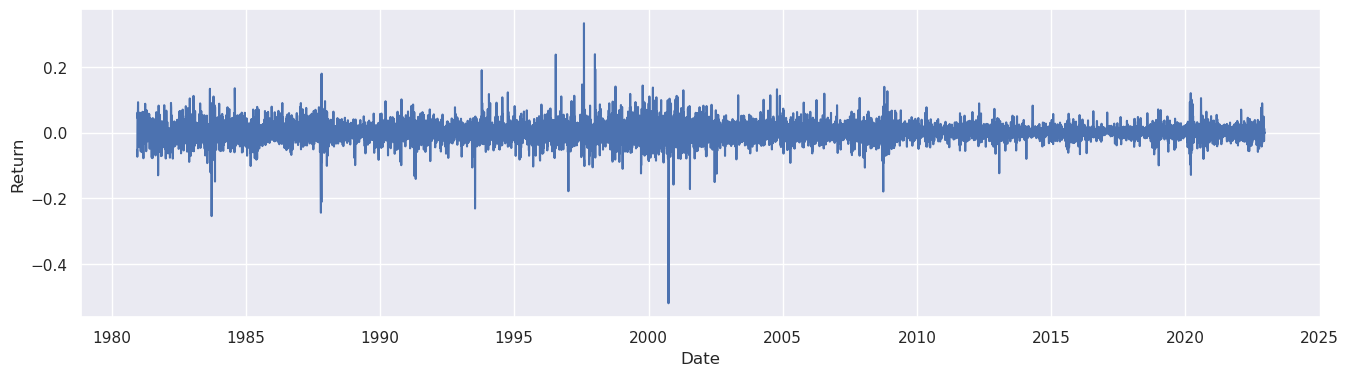

In [10]:
sns.lineplot(df, x='Date', y='Return')

In [11]:
df.corr()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Return
Date,1.000000,0.653000,0.652610,0.148241,0.652179,0.652567,0.639662,0.006559
Low,0.653000,1.000000,0.999924,-0.211637,0.999910,0.999926,0.999613,0.000408
Open,0.652610,0.999924,1.000000,-0.210775,0.999939,0.999840,0.999546,-0.001576
Volume,0.148241,-0.211637,-0.210775,1.000000,-0.210242,-0.210950,-0.213467,0.000913
High,0.652179,0.999910,0.999939,-0.210242,1.000000,0.999925,0.999657,0.000060
Close,0.652567,0.999926,0.999840,-0.210950,0.999925,1.000000,0.999712,0.002504
Adjusted Close,0.639662,0.999613,0.999546,-0.213467,0.999657,0.999712,1.000000,0.002377
Return,0.006559,0.000408,-0.001576,0.000913,0.000060,0.002504,0.002377,1.000000


In [12]:
df.iloc[df['Return'].idxmin()]

Date              2000-09-29 00:00:00
Low                          0.453125
Open                         0.503348
Volume                     7421640800
High                         0.517857
Close                        0.459821
Adjusted Close                0.39196
Return                      -0.518692
Name: 5004, dtype: object

<Axes: xlabel='Date', ylabel='Close'>

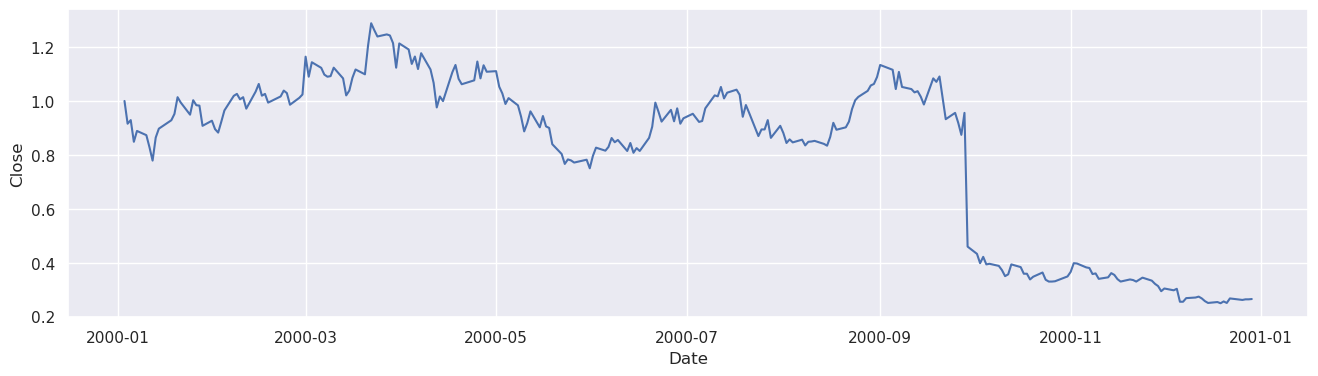

In [13]:
sns.lineplot(df[df['Date'].dt.strftime('%Y') == '2000'], x='Date', y='Close')

In [14]:
df.iloc[df['Return'].idxmax()]

Date              1997-08-06 00:00:00
Low                          0.223214
Open                         0.225446
Volume                     4190480000
High                         0.247768
Close                        0.234933
Adjusted Close               0.200261
Return                        0.33228
Name: 4209, dtype: object

<Axes: xlabel='Date', ylabel='Close'>

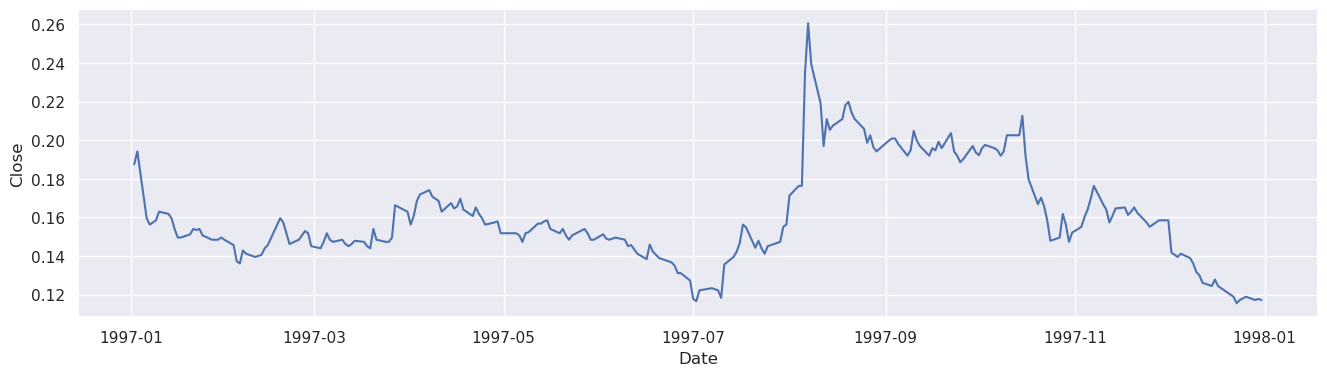

In [15]:
sns.lineplot(df[df['Date'].dt.strftime('%Y') == '1997'], x='Date', y='Close')